# XY - Modell

In [87]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scipy.stats import linregress
import pandas as pd
import sqlite3
import json
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (10, 6)

dpi = 300

# Select most recent run

In [88]:
con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id']

# Energy

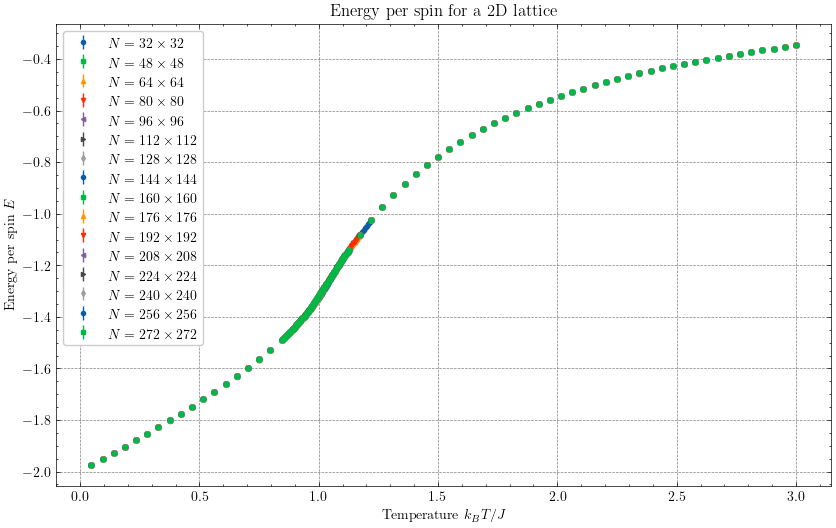

In [89]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['energy'], yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Energy per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Energy per spin $E$')

    ax.legend()

fig.savefig('figures/Energy.pdf', dpi=dpi,  bbox_inches='tight')

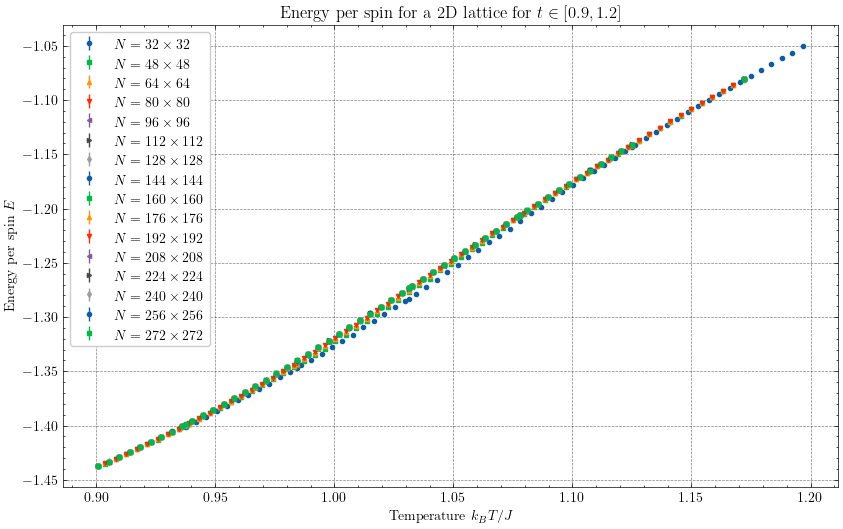

In [90]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' AND temperature >= 0.9 AND temperature <= 1.2 ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['energy'], yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Energy per spin for a 2D lattice for $t\\in [0.9,1.2]$')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Energy per spin $E$')

    ax.legend()

fig.savefig('figures/Energy_CloseUp.pdf', dpi=dpi,  bbox_inches='tight')

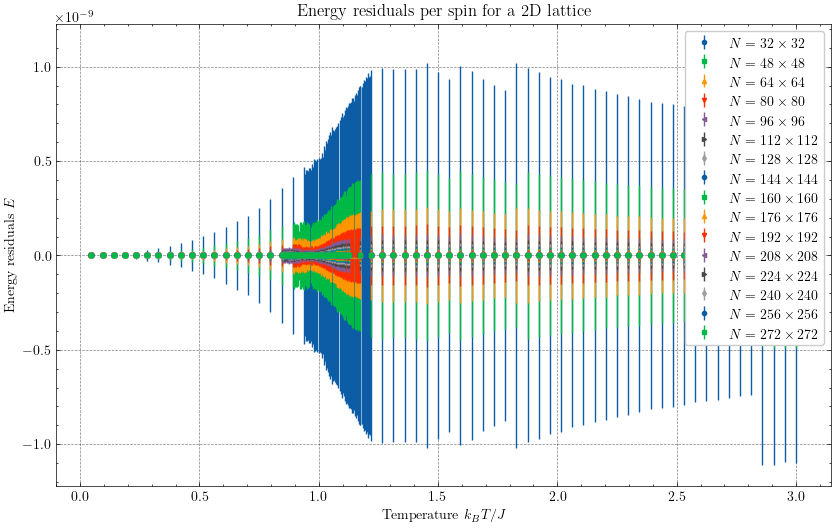

In [91]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], [0] * len(data['energy_std']), yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Energy residuals per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Energy residuals $E$')

    ax.legend()

fig.savefig('figures/Energy_Residual.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetisation

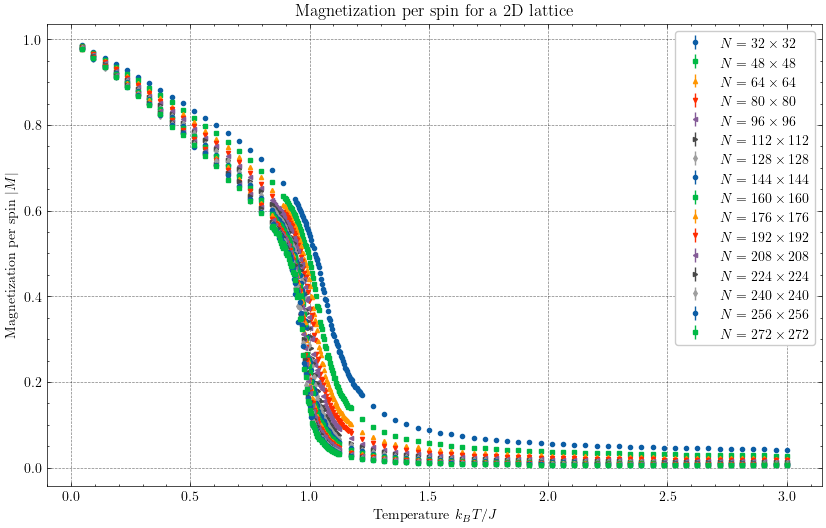

In [92]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size ORDER BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet'], yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Magnetization per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Magnetization per spin $\\lvert M \\rvert$')

    ax.legend()

fig.savefig('figures/Magnetization.pdf', dpi=dpi,  bbox_inches='tight')

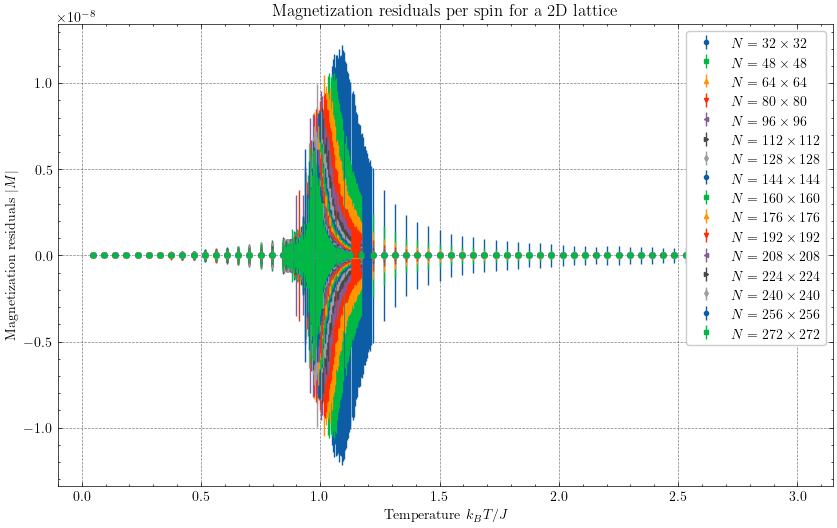

In [93]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size ORDER BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], [0] * len(data['magnet_std']), yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Magnetization residuals per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Magnetization residuals $\\lvert M \\rvert$')

    ax.legend()

fig.savefig('figures/Magnetization_Residuals.pdf', dpi=dpi,  bbox_inches='tight')

# Specific Heat

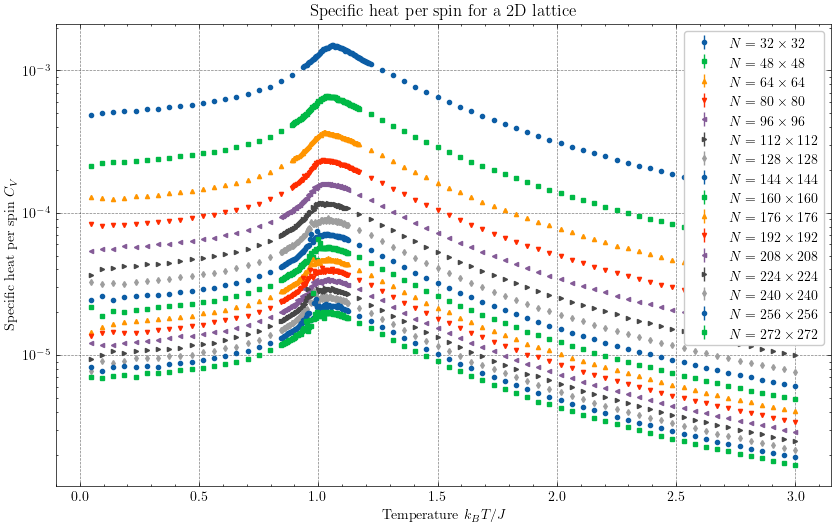

In [94]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size ORDER BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, specific_heat, specific_heat_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['specific_heat'], yerr=data['specific_heat_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Specific heat per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Specific heat per spin $C_V$')

    ax.set_yscale('log')
    ax.legend()

fig.savefig('figures/Specific_Heat.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetic susceptibility

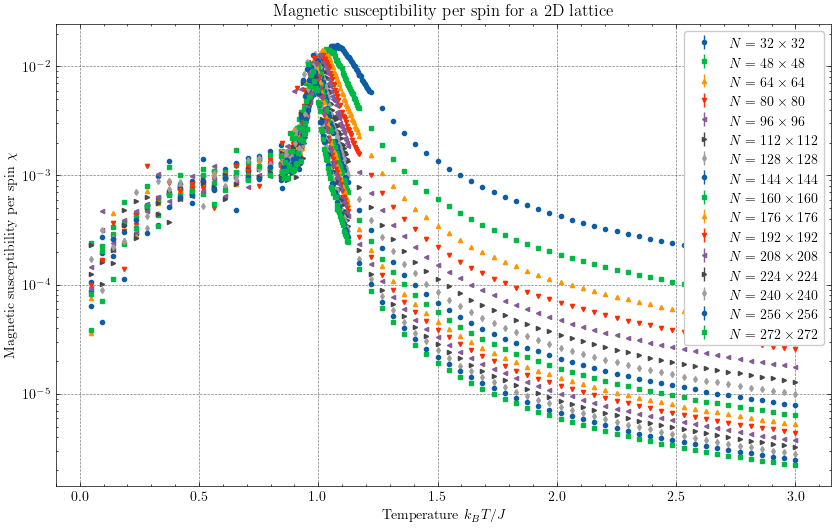

In [95]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size ORDER BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet_suscept, magnet_suscept_std FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet_suscept'], yerr=data['magnet_suscept_std'], label=f'$N = {size} \\times {size}$')

    ax.set_title(f'Magnetic susceptibility per spin for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Magnetic susceptibility per spin $\\chi$')

    ax.set_yscale('log')
    ax.legend()

fig.savefig('figures/Magnetic_Susceptibility.pdf', dpi=dpi,  bbox_inches='tight')

Bootstrap slope: 2.1910 +- 0.1106
Bootstrap intercept: 0.8940 +- 0.0056
Linear intercept: 0.8941 +- 0.0056
Linear slope: 2.1886 +- 0.1136


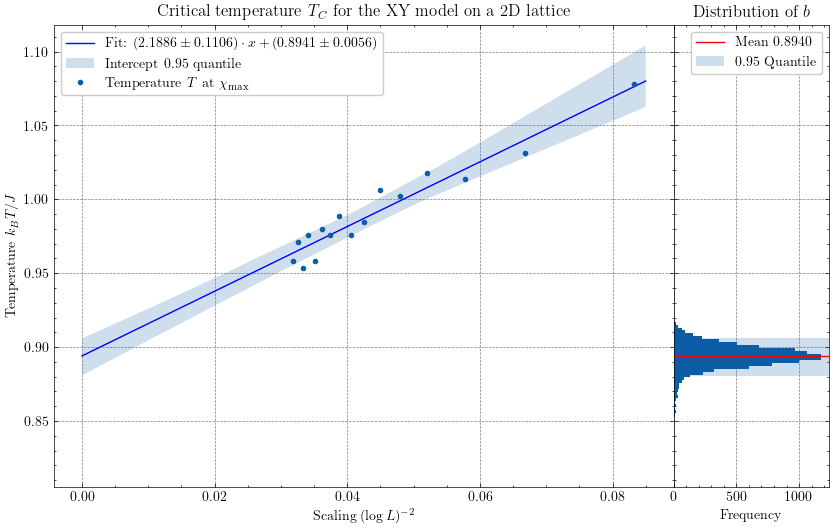

In [96]:
sampling = pd.Series(np.linspace(0, 0.085, num=100))
data = pd.read_sql_query(f'''SELECT 1.0 / POWER(LN(r.size), 2) AS size, r.temperature FROM (SELECT id, size, temperature, MAX(magnet_suscept) FROM results WHERE dimension = 2 AND run_id = 1 GROUP by size) AS r''', con)

# PLOT DATA POINTS
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0, 'hspace': 0}, sharey='row', sharex='col')
ax[0].errorbar(data['size'], data['temperature'], label=f'Temperature $T$ at $\\chi_\\text{{max}}$')

# BOOTSTRAP INTERCEPT
boot = pd.DataFrame()
for i in range(10_000):
    draw = data.sample(len(data), replace=True)
    res = linregress(draw['size'], draw['temperature'])

    new = pd.DataFrame({'slope': [res.slope], 'intercept': [res.intercept]})
    boot = pd.concat([boot, new])

# GETTING CUTOFFS FOR QUANTILE
slope_top_percentile = boot['slope'].quantile(0.95)
slope_bottom_percentile = boot['slope'].quantile(1.0 - 0.95)
intercept_top_percentile = boot['intercept'].quantile(0.95)
intercept_bottom_percentile = boot['intercept'].quantile(1.0 - 0.95)

# FILTER FOR QUANTILE
slope_quantile = boot[boot['slope'].ge(slope_bottom_percentile) & boot['slope'].le(slope_top_percentile)]
print(f'Bootstrap slope: {slope_quantile['slope'].mean():.4f} +- {slope_quantile['slope'].std():.4f}')

intercept_quantile = boot[boot['intercept'].ge(intercept_bottom_percentile) & boot['intercept'].le(intercept_top_percentile)]
print(f'Bootstrap intercept: {intercept_quantile['intercept'].mean():.4f} +- {intercept_quantile['intercept'].std():.4f}')

# GET CONFIDENCE INTERVAL FOR INTERCEPT
cross = intercept_quantile.merge(sampling.rename('x'), how='cross')
cross['y'] = cross.apply(lambda x: x['x'] * x['slope'] + x['intercept'], axis=1)

ymax = cross.groupby('x')['y'].max()
ymin = cross.groupby('x')['y'].min()

# PLOT REGRESSION
res = linregress(data['size'], data['temperature'])
print(f'Linear intercept: {res.intercept:.4f} +- {intercept_quantile['intercept'].std():.4f}')
print(f'Linear slope: {res.slope:.4f} +- {intercept_quantile['slope'].std():.4f}')

ax[0].plot(sampling, sampling * res.slope + res.intercept, 'b-', label=f'Fit: $({res.slope:.4f} \\pm {slope_quantile['slope'].std():.4f}) \\cdot x + ({res.intercept:.4f} \\pm {intercept_quantile['intercept'].std():.4f})$')
ax[0].fill_between(sampling, ymin, ymax, alpha=0.2, label=f'Intercept $0.95$ quantile')

ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $k_B T / J$')
ax[0].legend()

# PLOT CENTRAL LIMIT THEOREM
ax[1].hist(boot['intercept'], bins=50, orientation='horizontal')
ax[1].axhline(intercept_quantile['intercept'].mean(), color='red', label=f'Mean {intercept_quantile['intercept'].mean():.4f}')
ax[1].axhspan(intercept_bottom_percentile, intercept_top_percentile, alpha=0.2, label=f'$0.95$ Quantile')

ax[1].set_title('Distribution of $b$')
ax[1].set_xlabel('Frequency')
ax[1].legend()

fig.savefig('figures/Critical_Temperature.pdf', dpi=dpi,  bbox_inches='tight')

# Critical Slowing Down

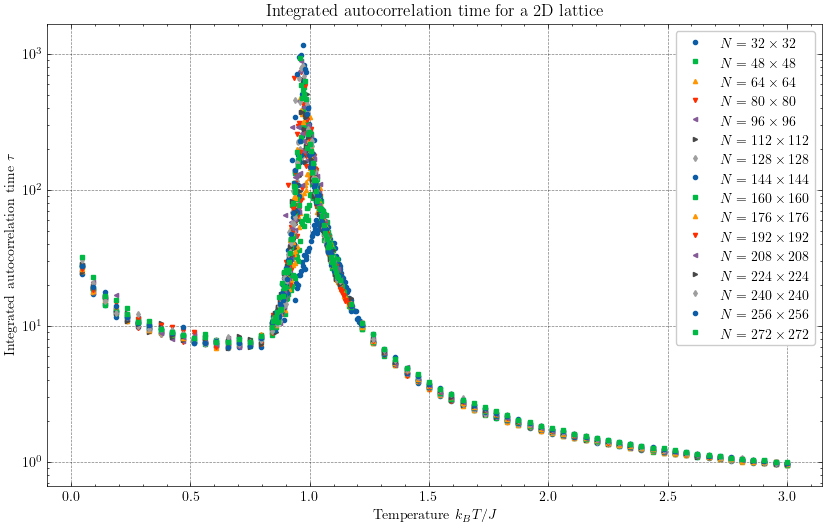

In [97]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY size ORDER BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy_tau FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['energy_tau'], label=f'$N = {size} \\times {size}$')

    ax.set_yscale('log')
    ax.set_title(f'Integrated autocorrelation time for a 2D lattice')
    ax.set_xlabel('Temperature $k_B T / J$')
    ax.set_ylabel('Integrated autocorrelation time $\\tau$')

    ax.legend()

fig.savefig('figures/Critical_Slowing_Down.pdf', dpi=dpi,  bbox_inches='tight')

# Scaling

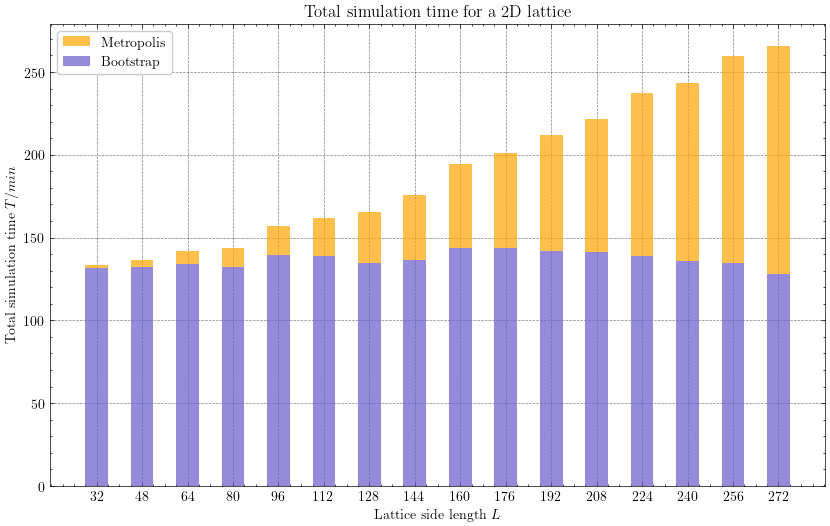

In [98]:
data = pd.read_sql_query(f'SELECT size, dimension, MAX(time_mc) / (60.0 * 1000) AS mc, SUM(time_boot) / (64.0 * 60 * 1000) AS boot FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size', con)

fig, ax = plt.subplots()
ax.bar(data['size'], data['mc'], width=8, alpha=0.7, color='orange', label='Metropolis', bottom=data['boot'])
ax.bar(data['size'], data['boot'], width=8, alpha=0.7, color='slateblue', label='Bootstrap')

ax.set_title(f'Total simulation time for a 2D lattice')
ax.set_xlabel('Lattice side length $L$')
ax.set_ylabel('Total simulation time $T / min$')
ax.set_xticks(data['size'], labels=data['size'])

ax.legend()

fig.savefig('figures/Time_Scaling.pdf', dpi=dpi,  bbox_inches='tight')

# Scheduling

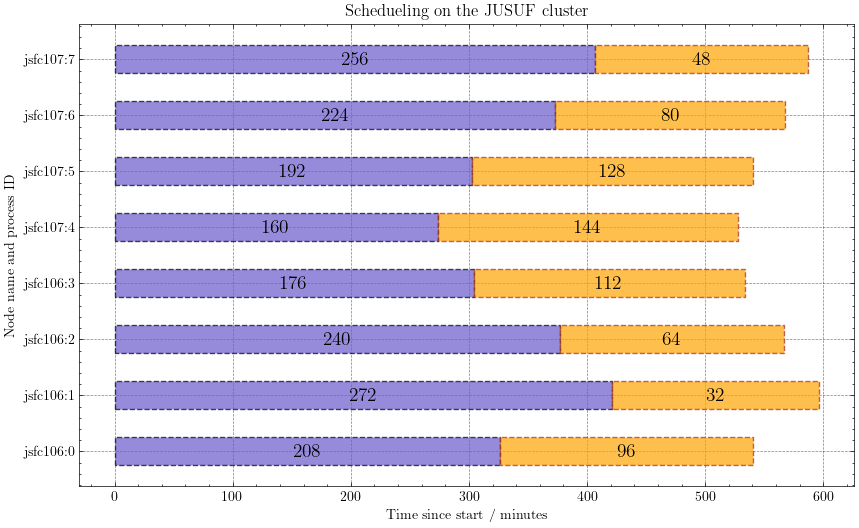

In [99]:
data = pd.read_sql_query(f'SELECT a.size, a.node, CAST(a.process AS TEXT) AS process, a.allocated_at / 60.0 AS allocated_at, (a.finished_at - a.allocated_at) / 60.0 AS duration FROM allocations AS a INNER JOIN results AS r ON r.run_id = a.run_id AND r.dimension = a.dimension AND r.size = a.size WHERE a.run_id = \'{current_run}\' AND a.dimension = 2 GROUP BY a.size, a.node, a.process, a.allocated_at ORDER BY a.node, a.process, allocated_at ASC', con)

min = data['allocated_at'].min()
data['allocated_at'] = data['allocated_at'].transform(lambda x: x - min)

fig, ax = plt.subplots()
for idx, (node, group) in enumerate(data.groupby(['node', 'process'])):
    allocations = list(group[['allocated_at', 'duration']].itertuples(index=False, name=None))
    ax.broken_barh(allocations, (idx * 1 - 0.25, 0.5), linewidth=1, color=['slateblue', 'orange'], alpha=0.7, edgecolor=['black', 'brown', 'green', 'blue'], linestyle='dashed')

    sizes = list(group[['size', 'allocated_at', 'duration']].itertuples(index=False, name=None))
    for size, x1, x2 in sizes:
        ax.text(x=x1 + x2/2, y=idx, s=size, ha='center', va='center', fontsize=14, weight='bold')

labels = list(map(lambda x: f'{x[0]}:{x[1]}', data[['node', 'process']].itertuples(index=False, name=None)))
ax.set_yticks(range(len(np.unique(labels))), labels=np.unique(labels))
ax.set_xlabel('Time since start / minutes')
ax.set_ylabel('Node name and process ID')
ax.set_title(f'Schedueling on the JUSUF cluster')

fig.savefig('figures/Schedueling.pdf', dpi=dpi,  bbox_inches='tight')

# Vortices

Frame: 0/2700700

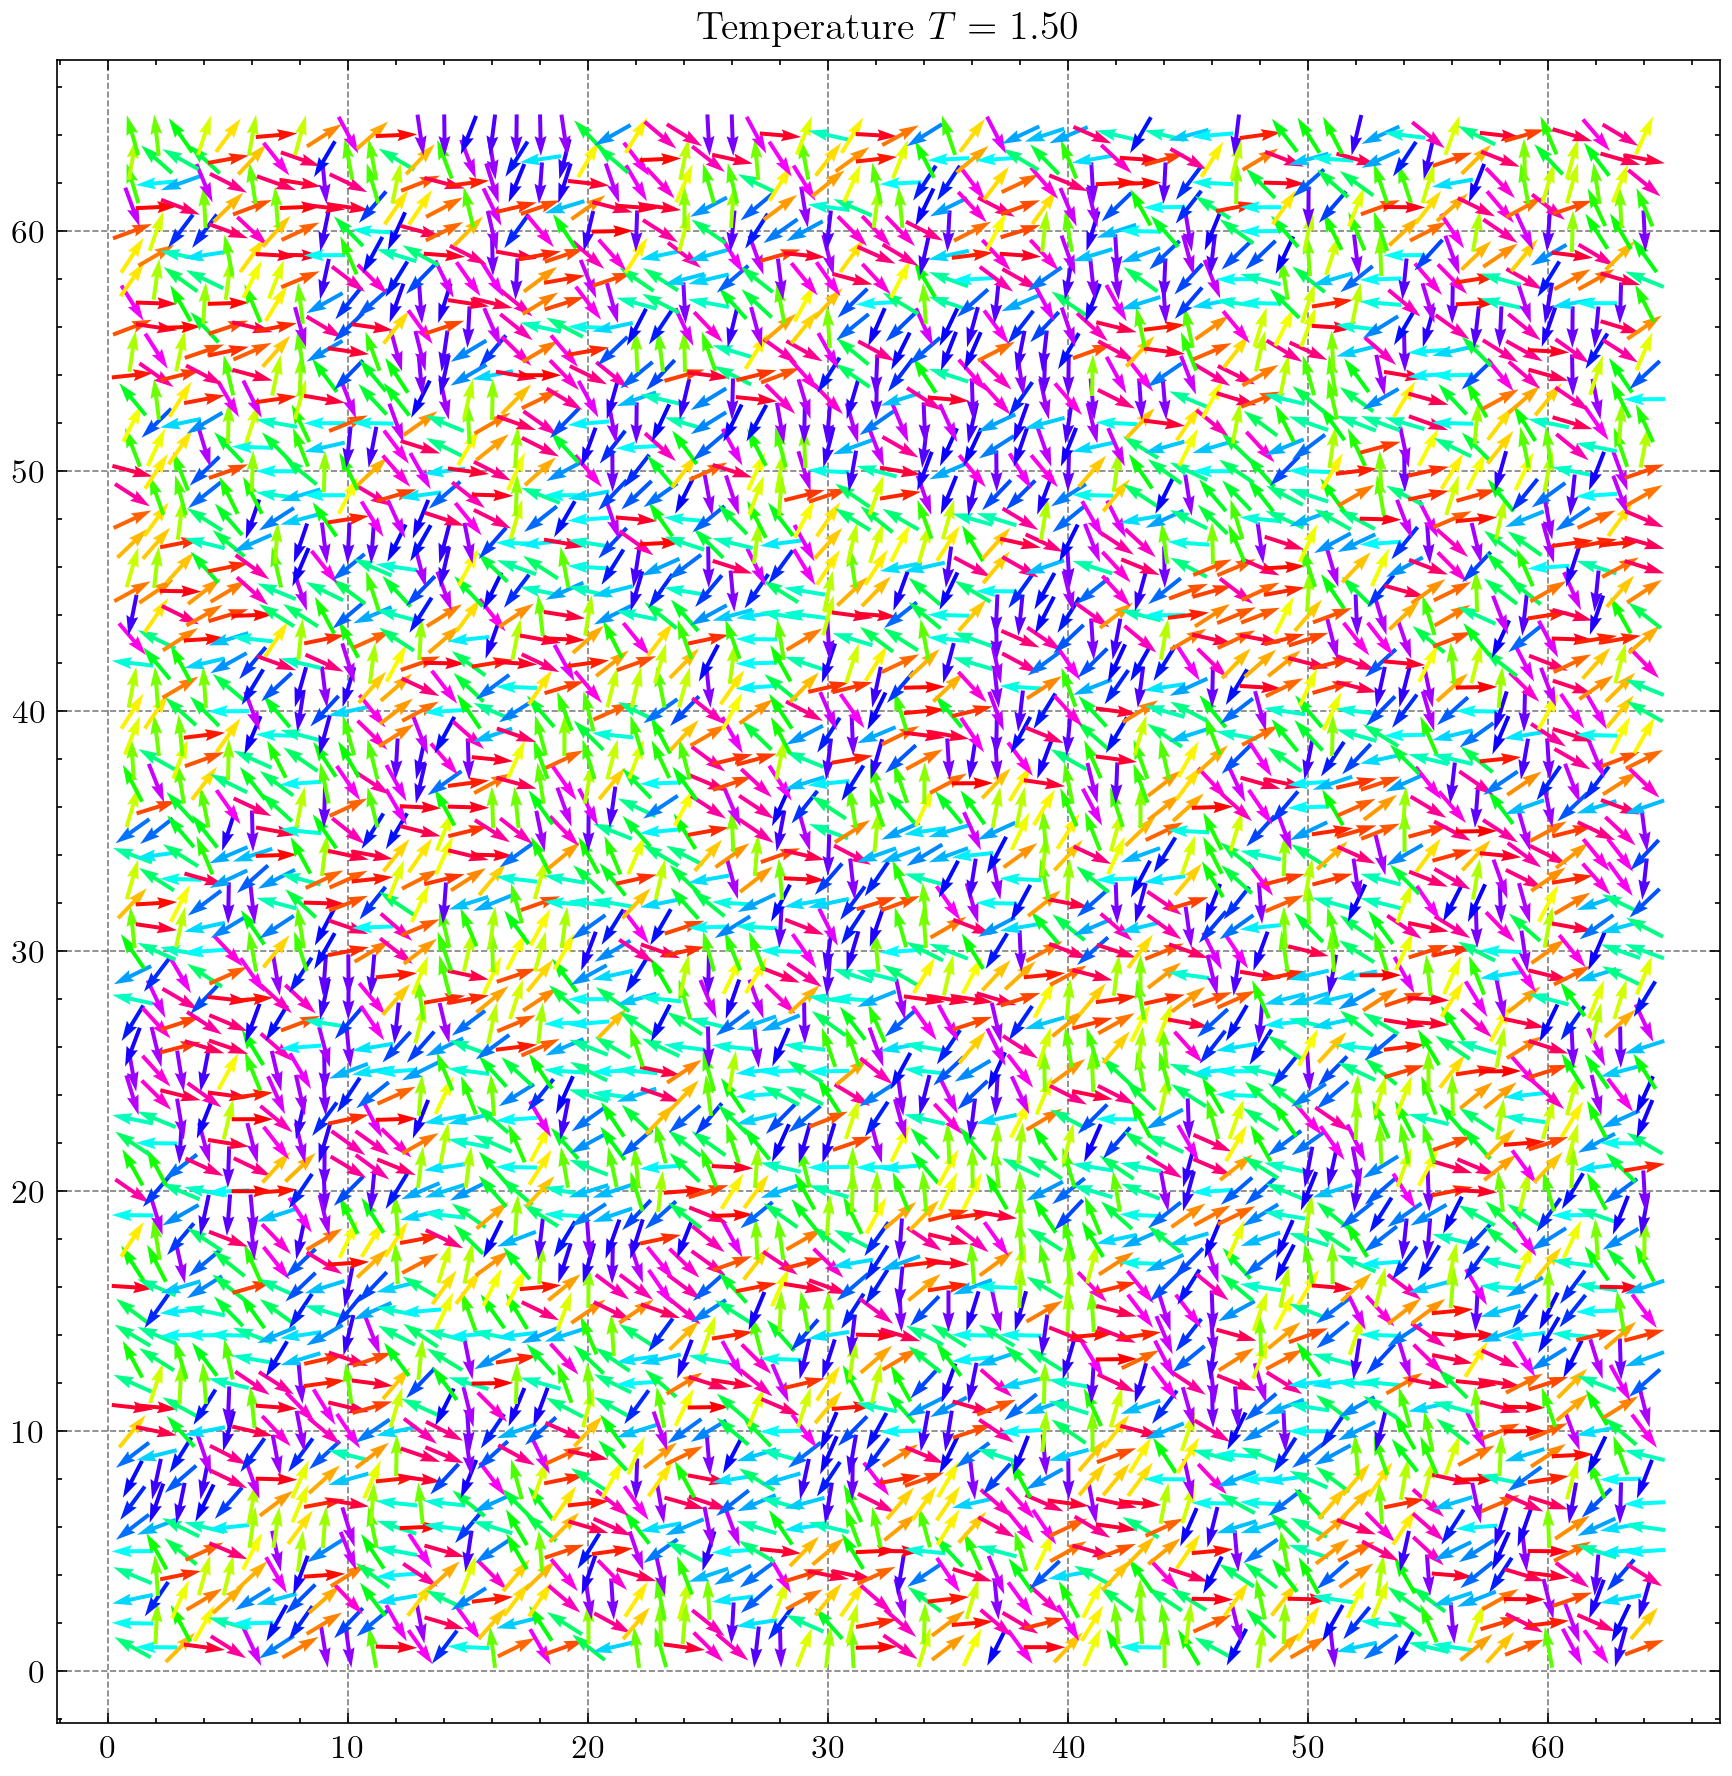

In [101]:
data = pd.read_sql_query(f'SELECT size, temperature, spins FROM vortices WHERE dimension = 2 AND run_id = \'{current_run}\' AND size = 64 ORDER BY id ASC', con)

fig, ax = plt.subplots(figsize=(16, 9), dpi=3840/16)
ax.set_box_aspect(1)

def animate(n: int):
    ax.cla()
    row = data.iloc[n]

    spins = np.array(json.loads(row['spins']))
    u = np.reshape(np.cos(spins), (-1, row['size']))
    v = np.reshape(np.sin(spins), (-1, row['size']))

    x = np.arange(1, row['size'] + 1, 1)
    y = np.arange(1, row['size'] + 1, 1)

    X, Y = np.meshgrid(x, y)
    ax.quiver(X, Y, u, v, spins, scale=40, pivot='middle', cmap='hsv')
    ax.set_title(f'Temperature $T={row['temperature']:.2f}$')

    print(f'\rFrame: {n}/{len(data)}', end='', flush=True)
    return fig

anim = FuncAnimation(fig = fig, func = animate, frames = 2400, interval = 1, repeat = False)

FFwriter = FFMpegWriter(fps=60, extra_args=['-vcodec', 'libx264', '-preset', 'veryslow', '-pix_fmt', 'yuv420p', '-crf', '23'])
anim.save('figures/vortices.mp4', writer=FFwriter)